## 用到的技巧：

### 数据增强，防止过拟合，增大数据集，可以训练更深的模型，提高预测率
- cutout
- Padding + RandomCrop
- mixup (暂时不用)

### data_loader 
- batch_size为2的幂次方,设置成2的幂性能优化,因为线程数通常是2^n这种数字
- pin_memory=(torch.cuda.is_available()，数据加载，如果有可能，在GPU上完成，提高速率

### nn.CELU代替nn.ReLU
平滑的激活函数对于优化过程也很有帮助

### 标签平滑
标签平滑是提高分类问题中神经网络训练速度和泛化的一个成熟技巧

### 用优化的SGD方法
- SGD小批量，则速度一定比全批量快，在大数据集尤其如此
- momentum 增加动量惯性
- weight_decay 即L2 regularization的系数，正则化
- nesterov = Ture，表示用nesterov momentum

torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9, weight_decay = 5e-4, nesterov = True)

带有动量的SGD本质：使用指数加权平均之后的梯度代替原梯度进行参数更新。详情请见 https://zhuanlan.zhihu.com/p/62585696

NAG（Nesterov Accelerated Gradient）的本质：多考虑了目标函数的二阶导信息。详情请见 https://zhuanlan.zhihu.com/p/22810533

### epoch设置和learning rate的实时更新
lr 更偏向于先升后降，最开始学习率比较小，中间学习率很高，最后学习率很低很低，最开始是为了预热，也为了防止SGD出现nan。 详情请见：
- 学习率先升后降： https://www.jiqizhixin.com/articles/041905
- 1cycle策略： SGD方法，大学习率（中间）时，momentum较小（0.85），小学习率时，momentum较大（0.95）。这也印证了一个直觉：在训练中，我们希望 SGD 可以迅速调整（大学习率）到搜索平坦区域的方向上，因此就应该对新的梯度赋予更大的权重（momentum相对变小）。 详情请见 https://cloud.tencent.com/developer/article/1118029
- 学习率调整的代码实现（提供包）： https://www.cnblogs.com/wanghui-garcia/p/10895397.html

### 初始化
xavier初始化： 为了使得网络中信息更好的流动，每一层输出的方差应该尽量相等。
参考： 
- https://zhuanlan.zhihu.com/p/25110150
- https://www.cnblogs.com/darkknightzh/p/8297793.html
- 代码实现： https://blog.csdn.net/qq_24724109/article/details/82050402

### 白化
原理：https://www.cnblogs.com/robert-dlut/p/4211174.html
实现：torchvision.transforms.LinearTransformation + np.linalg.eig

### maxpool 在 activation 前面，效果一样，可以节约时间

### Ghost批量归一（暂缺）

归一化（bn）最合适的批量大小大概在32左右。但在批量大小比较大的时候，比如512，降低其大小会严重影响训练时间。不过这一问题可以通过对batch的子集分别进行批量归一来解决，这种方法称为“ghost”批量归一。

In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

# 用tensorboard来可视化模型
from tensorboardX import SummaryWriter  # writer就相当于一个日志，保存你要做图的所有信息

In [4]:
# 设置随机数种子
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

setup_seed(20)

In [5]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

# Hyper-parameters for updating learning rate
num_epoches = 40
learning_rate = 0.1
batch_size = 128

# lr updating parameters
epoches = [1, 3, 4, 20, 21, 30, 31, 37, 38, num_epoches]
lrs = [learning_rate, 0.2, 0.1, 0.1, 0.01, 0.01, 0.001, 0.001, 0.0001, 0.0001]

In [6]:
# 数据增强方法：1.cutout
class Cutout(object):
    """Randomly mask out one or more patches（补丁，就是一个遮挡小块） from an image.
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            # (x,y)表示方形补丁的中心位置
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

# 2.Padding + RandomCrop,用transform自带函数做增强
# 3.mixup也是一种简单的数据增强方法,应用地方是在训练的时候，详见 https://blog.csdn.net/winycg/article/details/88410981
#   beta分布参见 https://www.cnblogs.com/think-and-do/p/6593809.html
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha) # beta分布
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# 4.label_smoothing 标签平滑是提高分类问题中神经网络训练速度和泛化的一个成熟技巧。
# 在Inception论文中提出，对标签label进行增强，作者认为one-hot编码会过拟合，因此作者在交叉熵中对错误label也分配了很小的权重来防止过拟合。
# 作者引入了参数ϵ, 详见 https://blog.csdn.net/winycg/article/details/88410981
# 在label_smoothing之后，loss的数值可能会增大一些，这与acuracy无关
def CrossEntropyLoss_label_smooth(outputs, targets, device,
                                  num_classes=10, epsilon=0.075):
    N = targets.size(0)
    smoothed_labels = torch.full(size=(N, num_classes),
                                 fill_value=epsilon / (num_classes - 1))
    smoothed_labels.scatter_(dim=1, index=torch.unsqueeze(targets.to('cpu'), dim=1),
                             value=1-epsilon)
    smoothed_labels = smoothed_labels.to(device)
    log_prob = nn.functional.log_softmax(outputs, dim=1)
    loss = - torch.sum(log_prob * smoothed_labels) / N
    return loss

In [7]:
# CIFAR-10 dataset
cifar_norm_mean = (0.49139968, 0.48215827, 0.44653124)
cifar_norm_std = (0.24703233, 0.24348505, 0.26158768)

train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                             train=True, 
                                             download=False,
                                             transform=transforms.Compose([
                                                 transforms.RandomCrop(32,padding = 4), #图像长宽周围都填充4个单位长度（像素）,
                                                                        #（32，32）->（40，40）,然后随机切割，切割完后的尺寸为32*32
                                                 transforms.RandomHorizontalFlip(),  #对PIL.image水平翻转，默认反转概率0.5
                                                 transforms.ToTensor(),  # totensor要放在这个固定的位置，之前是image，之后是normalize
                                                 transforms.Normalize(cifar_norm_mean, cifar_norm_std),
                                                 Cutout(n_holes=1, length=16)])
                                            )

test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                            train=False, 
                                            transform=transforms.Compose([
                                                transforms.ToTensor(),
                                                transforms.Normalize(cifar_norm_mean, cifar_norm_std)])                                   
                                            )

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,    # 设置成2的幂性能优化,因为线程数通常是2^n这种数字
                                           shuffle=True,
                                           #num_workers=2,
                                           pin_memory=(torch.cuda.is_available()),
                                           )

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          #num_workers=2,
                                          pin_memory=(torch.cuda.is_available()),
                                          )

# Cifar-10的标签
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
                                                 
print(train_dataset,'\n')
print(train_dataset[0][0].shape,'\n')            #第1个数据的X,这里目前由于是ToTensor的结果，是tensor，暂时没有被padding
print(train_dataset[0][1],'\n')            #第1个数据的y
print(train_dataset.targets[0],'\n')       #等同于第1个数据的y

batch=next(iter(train_loader))
images,labels = batch
print(images.shape)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.49139968, 0.48215827, 0.44653124), std=(0.24703233, 0.24348505, 0.26158768))
           ) 

torch.Size([3, 32, 32]) 

6 

6 

torch.Size([128, 3, 32, 32])


In [79]:
# 3x3 convolution，定义3*3的卷积层（因为kernel_size为3）,步长默认为1，这样的话kernel_size为3，步长为1，最后图像的长宽不变
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

In [80]:
# Residual block
class ResidualBlock(nn.Module): # stride=1时，(batch,in_c,w,h) -> (batch,out_ch_c,w,h)
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)  # (batch,in_c,w,h) -> (batch,out_c,w/stride,h/stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.celu = nn.CELU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)         # (batch,out_c,w,h) -> (batch,out_c,w,h)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.celu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:  # downsample的作用：仍然是一个3x3 conv+ bn
            residual = self.downsample(x) 
        out += residual      # 相当于那个经典的图的x（如果有downsample,则是self.downsample）直接连到了输出，想一想残差原理，
                             # 以及反向传递的时候避开了downsample走在主线上
        out = self.celu(out)
        return out
    
# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):     #这个block传递的是ResidualBlock类,layers传递的是[2,2]
        super(ResNet, self).__init__()
        # prep
        self.conv1 = conv3x3(3, 16)         #(batch,3,32,32) -> (batch,16,32,32)
        self.bn1 = nn.BatchNorm2d(16)
        self.celu1 = nn.CELU(inplace=True)
        
        #layer1_ens
        self.conv2 = conv3x3(16, 16)         #(batch,16,32,32) -> (batch,16,32,32)
        self.bn2 = nn.BatchNorm2d(16)
        self.max_pool1 = nn.MaxPool2d(2,2)   # (batch,16,32,32) -> (batch,16,16,16)
        self.celu2 = nn.CELU(inplace=True)
        self.layer1 = self.make_layer(block, 16, 32, layers[0], 2) #layers[0]为2，则最后有1+1个block,(b,16,16,16)->(这里有一个downsample)(b,32,8,8)->(b,32,8,8)
        
        # layer2_ens
        self.conv3 = conv3x3(32, 64)         #(batch,32,8,8) -> (batch,64,8,8)
        self.bn3 = nn.BatchNorm2d(64)
        self.max_pool2 = nn.MaxPool2d(2,2)   # (batch,64,8,8) -> (batch,64,4,4)
        self.celu3 = nn.CELU(inplace=True)   # celu2如果不用celu1的，就新开辟了空间，画图时候会区分开
        
        # layer3_ens
        self.conv4 = conv3x3(64, 64)         #(batch,64,4,4) -> (batch,64,4,4)
        self.bn4 = nn.BatchNorm2d(64)
        self.max_pool3 = nn.MaxPool2d(2,2)   # (batch,64,2,2) -> (batch,64,2,2)
        self.celu4 = nn.CELU(inplace=True)
        self.layer2 = self.make_layer(block, 64, 128, layers[1], 2) #layers[0]为2，则最后有1+1个block,(b,64,2,2)->(这里有一个downsample)(b,128,1,1)->(b,128,1,1)
        
        #self.avg_pool = nn.AvgPool2d(4)           # kernel_size 为4,若输入是(c,w,h),则输出是(c,w-3,h-3),则(b,128,4,4) -> (b,128,1,1)
                                                  # 这里最后用avg pool好，因为这里这4个数值元素更多的是平等关系，为了减小方差
        self.fc = nn.Linear(128, num_classes)     # (b,128,1,1)经过view(out.size(0),-1)之后变成了(b,256),这里out.size(0)为b,再经过fc变成(b,10)
        
    def make_layer(self, block, in_channels, out_channels, blocks, stride=1): # blocks表示block的数目
        downsample = None
        if (stride != 1) or (in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(in_channels, out_channels, stride, downsample))
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # prep
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.celu1(out)
        
        #layer1_ens
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.max_pool1(out)
        out = self.celu2(out)
        out = self.layer1(out)
        
        # layer2_ens
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.max_pool2(out)
        out = self.celu3(out)
        
        # layer3_ens
        out = self.conv4(out)
        out = self.bn4(out)
        out = self.max_pool3(out)
        out = self.celu4(out)
        out = self.layer2(out)

        #out = self.avg_pool(out)
        out = out.view(out.size(0), -1)      # 由(b,64,1,1) 变成了 (b,64)
        out = self.fc(out)
        return out

In [8]:
model = ResNet(ResidualBlock, [2, 2]).to(device)

# 保存模型结构
dummy_input = torch.rand(20, 3, 32, 32).to(device)  # 假设输入20张3*32*32的图片
with SummaryWriter(comment='Resnet9') as w:
    w.add_graph(model, (dummy_input,))
    
print('# model parameters:', sum(param.numel() for param in model.parameters()))
    
# 如果要看模型，需要：
# 1.在你的terminal（终端）中 ，在D:\我的代码\jupyter notebook\Programs\CIFAR10\runs 地址下，使用以下命令
# tensorboard --logdir Nov20_21-13-56_LAPTOP-F48B5MHEResnet9
# 2.在浏览器输入
# http://localhost:6006

# model parameters: 687930


In [9]:
# prediction function
def pred_rate(preds,labels):
    return preds.eq(labels).sum().item()/labels.shape[0]

# For updating learning rate
def piecewise_linear(optimizer, curr_epoch, epoches, lrs):  # 注意,epoches 是list，如[0,40,60],lrs也是list如[0.1,0.3,0],这里从0开始计算
                                                        # 表示1~20epoch时，lr是0~0.4的线性升高，21~60epoch时，lr是0.4~0的线性下降
    length = len(lrs)
    for i in range (length-1):
        if curr_epoch > epoches[i] and curr_epoch < epoches[i+1]:
            lr = lrs[i] + (curr_epoch-epoches[i])/(epoches[i+1]-epoches[i])*(lrs[i+1]-lrs[i])
            break
        elif curr_epoch == epoches[i]:
            lr = lrs[i]
            break
        elif curr_epoch == epoches[-1]:        # 考虑最后一个epoch的特殊情况
            lr = lrs[-1]
            break

    # print
    #if lrs[i] == lrs[i+1]:
        #print('Epoch [{}/{}], learning rate kept still in {}'.format(epoch+1, num_epoches, lr))
    #else:
        #print('Epoch [{}/{}], learning rate updated to {}'.format(epoch+1, num_epoches, lr))
    
    # update lr
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
    return lr

In [10]:
# Loss and optimizer
# criterion 要写在后面
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9, weight_decay = 5e-4, nesterov = True)

In [9]:
# Reload the model
model = ResNet(ResidualBlock, [2, 2]).to(device)
model.load_state_dict(torch.load('resnet9_piecewise_linear.ckpt'))

<All keys matched successfully>

In [19]:
# 画图
loss_ens = []
lr_ens = [learning_rate]
pred_rate_ens = []

# Train the model
total_step = len(train_loader)
for epoch in range(num_epoches):
    for i, (images, labels) in enumerate(train_loader):
        images,labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = CrossEntropyLoss_label_smooth(outputs, labels, device)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 98 == 0:
            preds=outputs.argmax(dim=1)
            print ("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Prediction rate: {:.4f}"
                   .format(epoch+1, num_epoches, i+1, total_step, loss.item(), pred_rate(preds,labels)))
            
            # 保存数据以画图
            pred_rate_ens.append(pred_rate(preds,labels))
            loss_ens.append(loss.item())
            
    # update learning rate
    curr_lr = piecewise_linear(optimizer, epoch+1, epoches, lrs)
    # 保存数据以画图
    lr_ens.append(curr_lr)

Epoch [1/50], Step [98/196], Loss: 0.8195, Prediction rate: 0.8359
Epoch [1/50], Step [196/196], Loss: 0.7825, Prediction rate: 0.8125
Epoch [1/50], learning rate kept still in 0.0005
Epoch [2/50], Step [98/196], Loss: 0.7790, Prediction rate: 0.8633
Epoch [2/50], Step [196/196], Loss: 0.9195, Prediction rate: 0.7750
Epoch [2/50], learning rate kept still in 0.0005
Epoch [3/50], Step [98/196], Loss: 0.7420, Prediction rate: 0.8750
Epoch [3/50], Step [196/196], Loss: 0.8267, Prediction rate: 0.8500
Epoch [3/50], learning rate kept still in 0.0005
Epoch [4/50], Step [98/196], Loss: 0.8522, Prediction rate: 0.8281
Epoch [4/50], Step [196/196], Loss: 0.7268, Prediction rate: 0.8750
Epoch [4/50], learning rate kept still in 0.0005
Epoch [5/50], Step [98/196], Loss: 0.7386, Prediction rate: 0.9062
Epoch [5/50], Step [196/196], Loss: 0.8664, Prediction rate: 0.7875
Epoch [5/50], learning rate kept still in 0.0005
Epoch [6/50], Step [98/196], Loss: 0.8449, Prediction rate: 0.8242
Epoch [6/50],

Epoch [45/50], Step [98/196], Loss: 0.8287, Prediction rate: 0.8242
Epoch [45/50], Step [196/196], Loss: 0.8320, Prediction rate: 0.8375
Epoch [45/50], learning rate kept still in 0.0001
Epoch [46/50], Step [98/196], Loss: 0.8159, Prediction rate: 0.8359
Epoch [46/50], Step [196/196], Loss: 0.7847, Prediction rate: 0.8500
Epoch [46/50], learning rate kept still in 0.0001
Epoch [47/50], Step [98/196], Loss: 0.7892, Prediction rate: 0.8516
Epoch [47/50], Step [196/196], Loss: 0.9121, Prediction rate: 0.7500
Epoch [47/50], learning rate kept still in 0.0001
Epoch [48/50], Step [98/196], Loss: 0.7893, Prediction rate: 0.8594
Epoch [48/50], Step [196/196], Loss: 0.8166, Prediction rate: 0.8250
Epoch [48/50], learning rate kept still in 0.0001
Epoch [49/50], Step [98/196], Loss: 0.8405, Prediction rate: 0.8359
Epoch [49/50], Step [196/196], Loss: 0.8050, Prediction rate: 0.8375
Epoch [49/50], learning rate kept still in 0.0001
Epoch [50/50], Step [98/196], Loss: 0.7967, Prediction rate: 0.84

NameError: name 'pred_rate_ens' is not defined

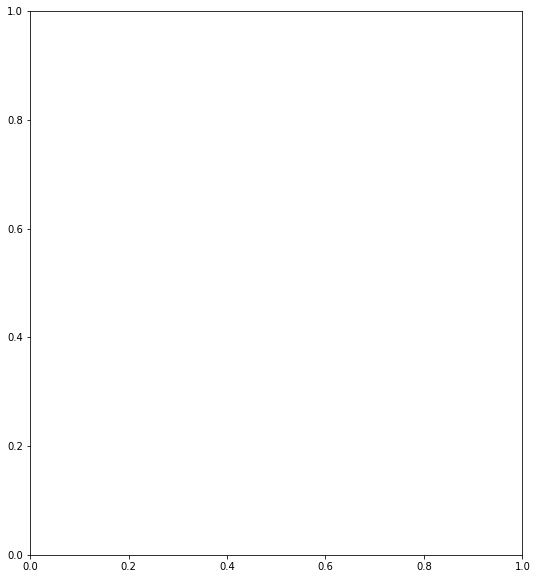

In [10]:
# draw the loss, pred_rate with iteration andd the lr with epoch
plt. figure(figsize=(30,10))

plt.subplot(131)
plt.plot(np.arange(1,len(pred_rate_ens)+1),pred_rate_ens)
plt.title('prediction rate')
plt.xlabel('iteration')

plt.subplot(132)
plt.plot(np.arange(1,len(loss_ens)+1),loss_ens)
plt.title('loss')
plt.xlabel('iteration')

plt.subplot(133)
plt.plot(np.arange(num_epoches+1),lr_ens)
plt.title('learning rate')
plt.xlabel('epoch')

plt.show()

In [24]:
# Save the model checkpoint，保存的是模型的参数，则保存和读取跟直接保存模型不太一样,但是这个方法成本小
torch.save(model.state_dict(), 'resnet9_piecewise_linear.ckpt')

In [25]:
# Test the model
model = ResNet(ResidualBlock, [2, 2]).to(device)
model.load_state_dict(torch.load('resnet9_piecewise_linear.ckpt'))

model.eval()
with torch.no_grad():         # 使用 torch,no_grad()构建不需要track的上下文环境，这个时候再不会跟踪track各个tensor的梯度
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 86.59 %
